In [1]:
import datetime
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
sc.logging.print_memory_usage()
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi = 300, dpi_save = 300)
sc.logging.print_header()
from matplotlib.pyplot import rc_context

Memory usage: current 0.19 GB, difference +0.19 GB
scanpy==1.10.2 anndata==0.10.8 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.0.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [3]:
import decoupler as dc

In [4]:
# add the utility functions folder to PATH
sys.path.append(os.path.abspath("../packages"))
from db_dev.helper import *

In [5]:
import matplotlib as mpl
mpl.rc("font", family = "Arial")
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42


In [7]:
#load data with leiden
#home_dir = os.path.expanduser("~")
current_directory = os.getcwd()
adata = sc.read_h5ad(current_directory+"/backups/bb2_bb3_leiden_2.5_sub_DGE_refined_annotation_86447x37733_241107_10h51.h5ad")

In [8]:
#Loading obs
current_directory = os.getcwd()
# overwrite obs with the most recent version
filename = current_directory+"/backups/anno_obs_info_86447x39_250127_18h19.npz"
encoding = "latin1"

with np.load(filename, encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)

obs_cell_type_sub_prolif_anno = obs[["barcode", "library", "cell_type_sub_prolif_anno"]]

# Perform a left join
updated_obs = adata.obs.merge(obs_cell_type_sub_prolif_anno, on=["library", "barcode"], how="left")

# Update the adata.obs with the new annotations
adata.obs = updated_obs



In [18]:
# exclude patients with monocytic blasts

adata = adata[(adata.obs["code"] != "1-FM02-NP0000032") & (adata.obs["code"] != "1-FM02-NP0000045")].copy()

/Users/denis/mambaforge/envs/capseq_dge/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [20]:
#subset adata

select_cell_type = "CD14 Monocytes"


select_control_sample = "KC"
select_condition_sample = "UL"


select_sample = [
    select_condition_sample,
    select_control_sample
]
sample_mask = adata.obs["sample"].isin(select_sample)



In [21]:
adata = adata[sample_mask].copy()

In [24]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col = "sample_code",
    groups_col = "cell_type_sub_prolif_anno",
    layer = "counts",
    mode = "sum",
    min_cells = 10,
    min_counts = 1000
)
pdata

AnnData object with n_obs × n_vars = 205 × 31568
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo'
    layers: 'psbulk_props'

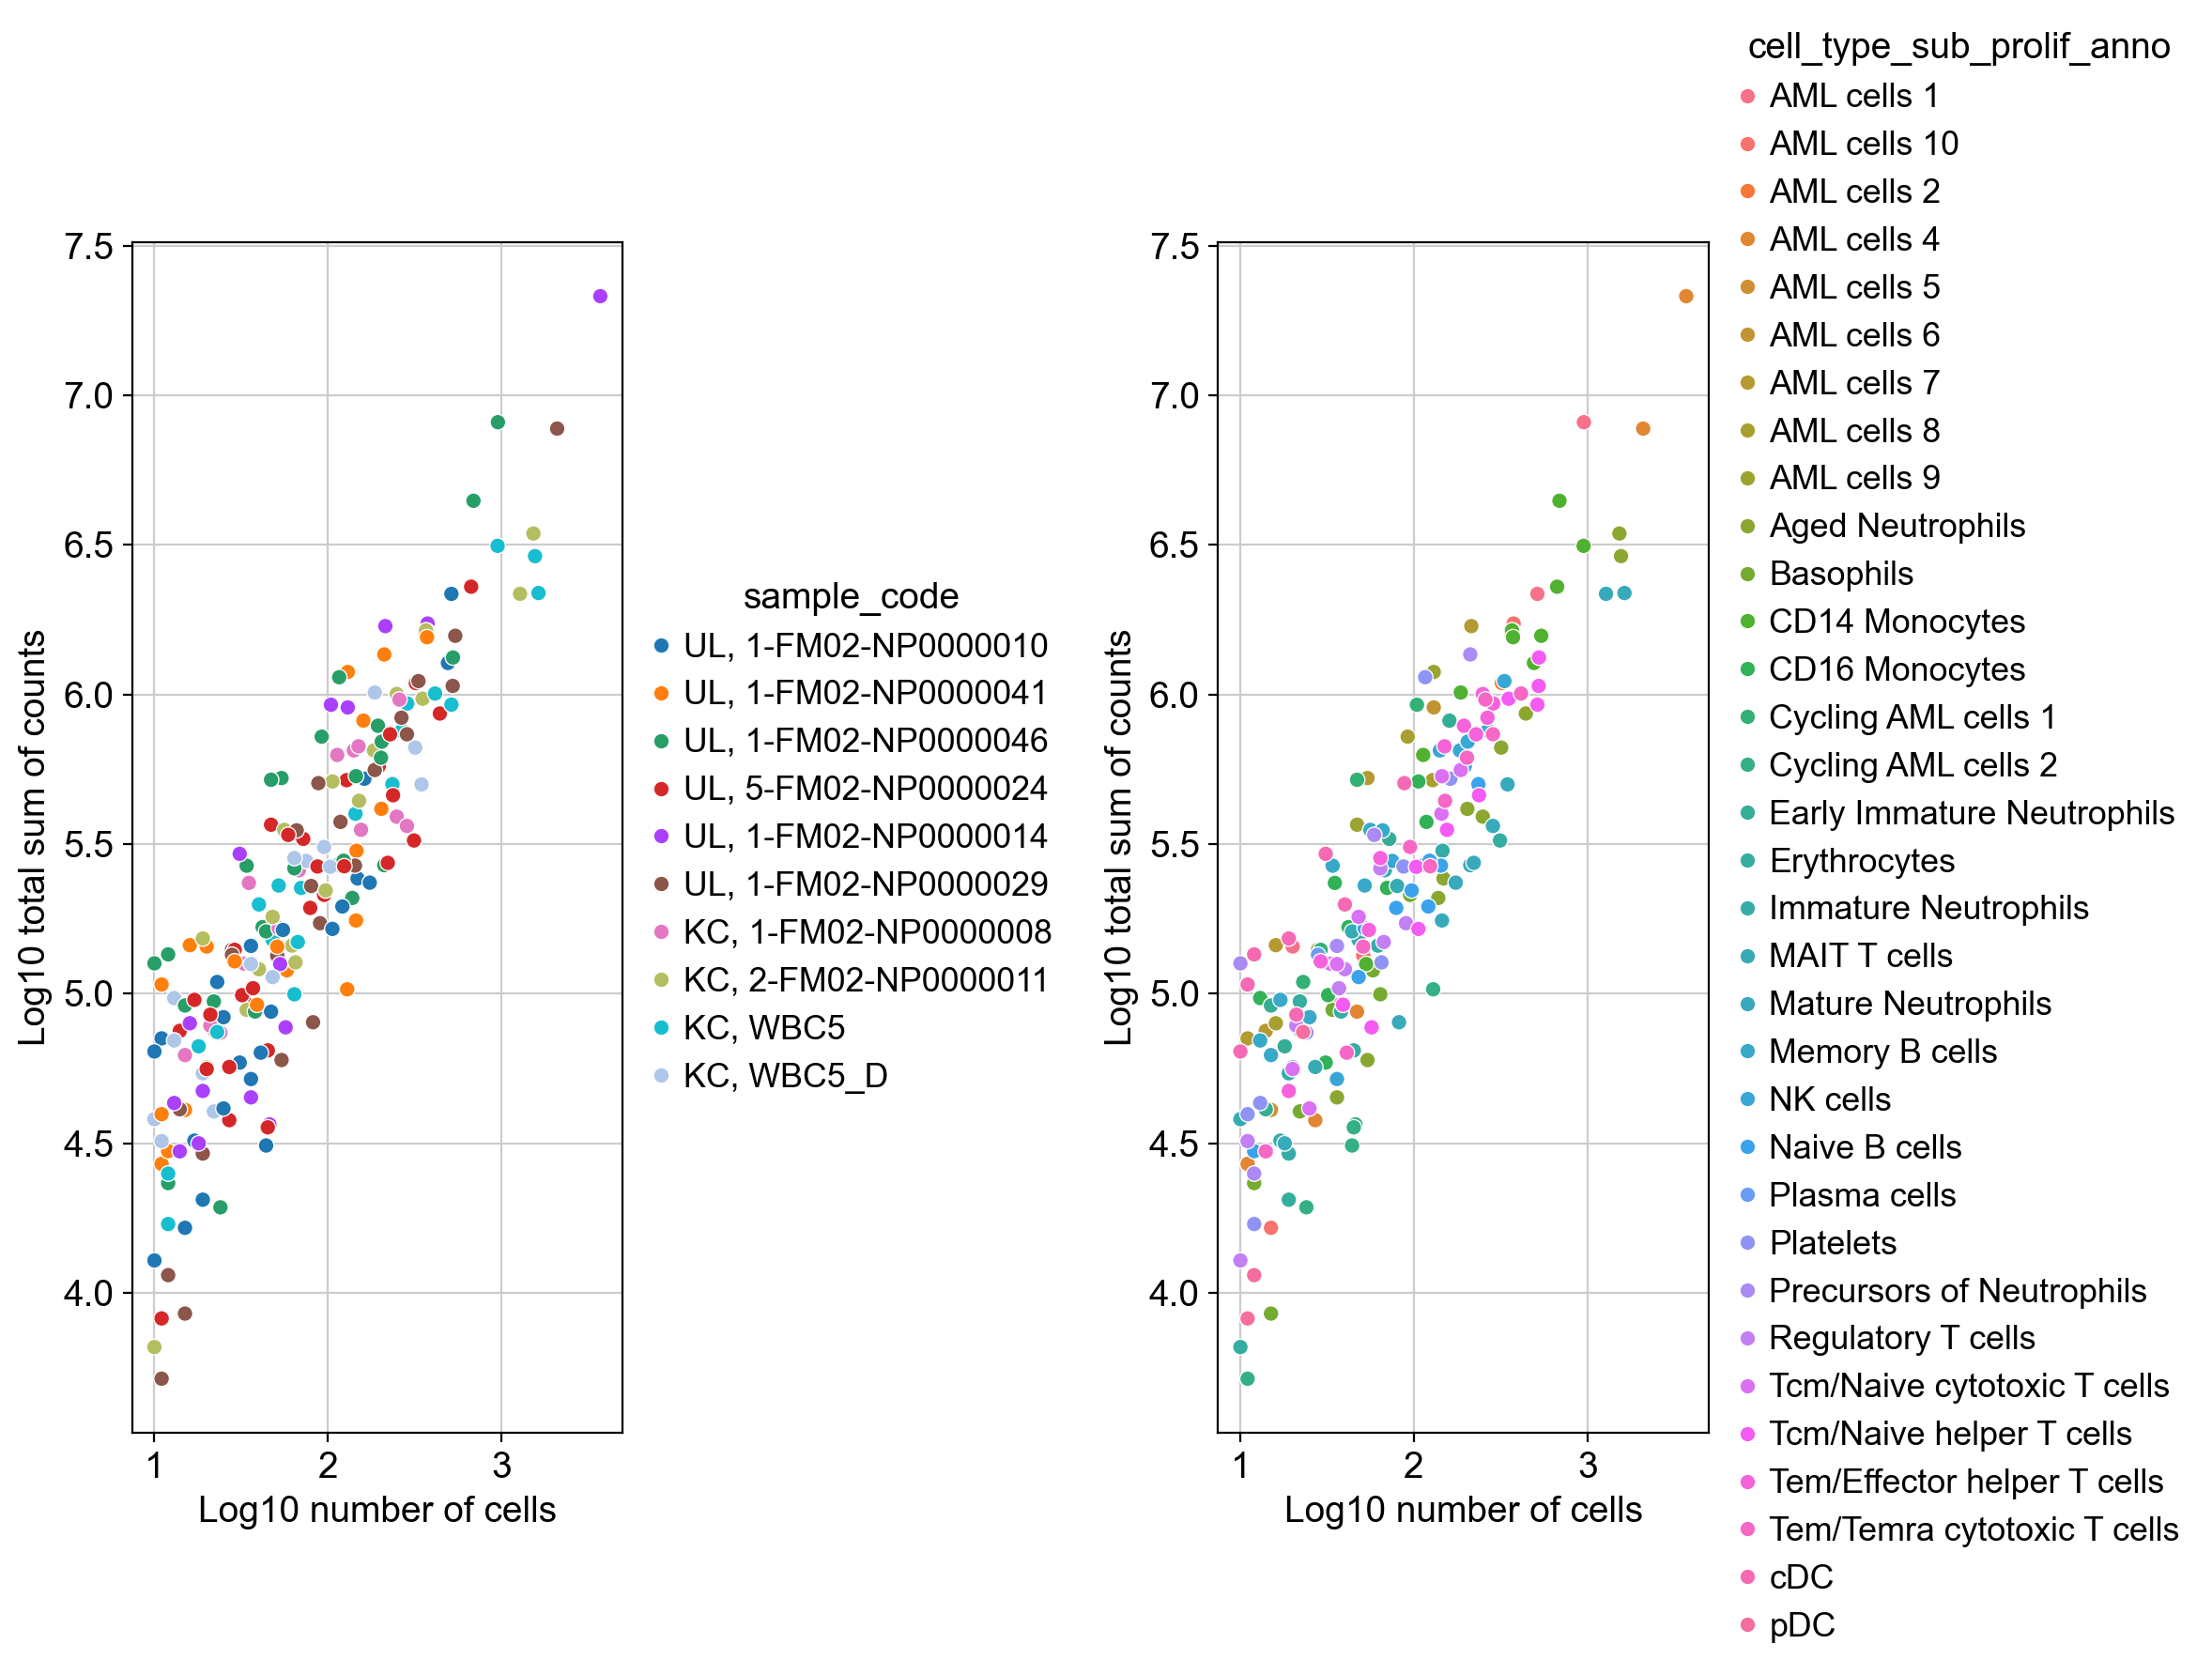

In [25]:
dc.plot_psbulk_samples(pdata, groupby=["sample_code", "cell_type_sub_prolif_anno"], figsize=(12, 9))

In [26]:
pdata

AnnData object with n_obs × n_vars = 205 × 31568
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo'
    layers: 'psbulk_props'

In [27]:
# Store raw counts in layers
pdata.layers["counts"] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum = 1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value = 10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, "counts", X_layer_key=None, inplace=True)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


In [28]:
pdata

AnnData object with n_obs × n_vars = 205 × 31568
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [29]:
# Select CD14 Monocytes profiles
print(select_cell_type)
cd14_monocytes = pdata[pdata.obs["cell_type_sub_prolif_anno"] == select_cell_type].copy()

CD14 Monocytes


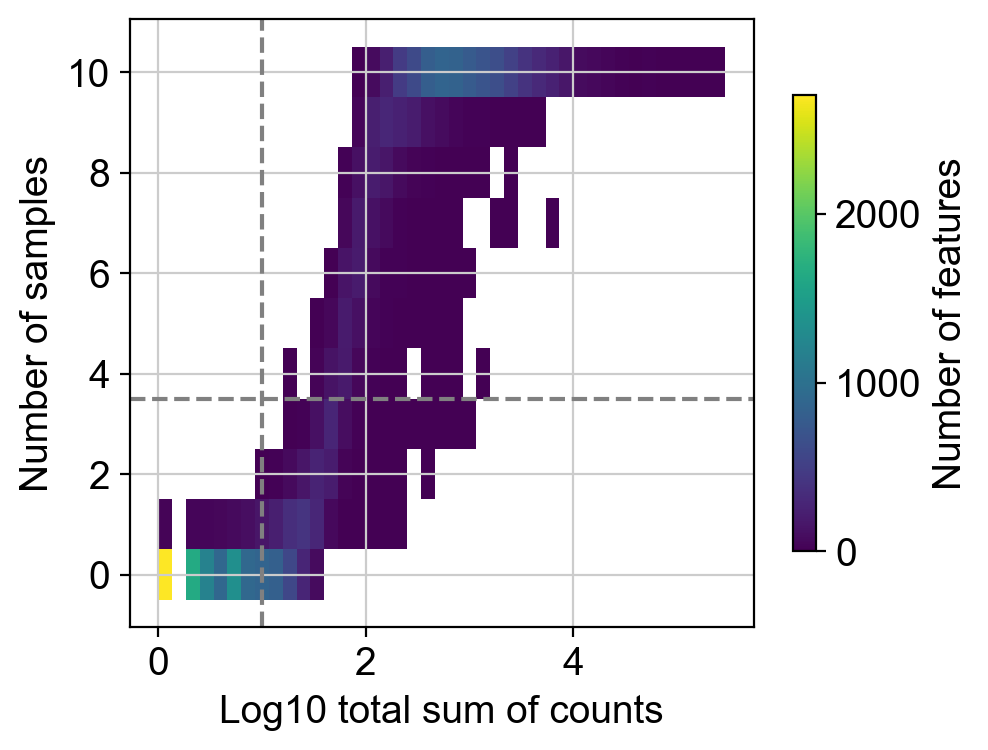

In [30]:
dc.plot_filter_by_expr(cd14_monocytes, group = "sample", min_count = 5, min_total_count = 10)


In [31]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(cd14_monocytes, group = "sample", min_count = 5, min_total_count = 10)

# Filter by these genes
cd14_monocytes = cd14_monocytes[:, genes].copy()
cd14_monocytes


AnnData object with n_obs × n_vars = 10 × 11455
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [32]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [33]:
cd14_monocytes.obs["sample"].unique()

array(['KC', 'UL'], dtype=object)

In [34]:
# Build DESeq2 object
inference = DefaultInference(n_cpus = 8)
dds = DeseqDataSet(
    adata = cd14_monocytes,
    design_factors = "sample",
    ref_level = ["sample", select_control_sample],
    refit_cooks = True,
    inference = inference,
)

In [35]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.38 seconds.

Fitting dispersion trend curve...
... done in 0.17 seconds.

Fitting MAP dispersions...
... done in 1.55 seconds.

Fitting LFCs...
... done in 0.86 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [36]:
# Extract contrast between AML vs HD
stat_res = DeseqStats(
    dds,
    contrast=["sample", select_condition_sample, select_control_sample],
    inference = inference,
)

In [37]:
# Compute Wald test
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: sample UL vs KC
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        10.398895       -0.066776  0.601522 -0.111011  0.911608  0.993659
A1BG-AS1     6.818397        0.186806  0.582909  0.320472  0.748611  0.970914
A2ML1-AS1    6.424301       -0.017261  0.993689 -0.017370  0.986141  0.999069
A3GALT2      4.829612       -0.657586  0.758944 -0.866449  0.386244  0.875945
AAAS        14.651877       -0.071548  0.510160 -0.140246  0.888465  0.991367
...               ...             ...       ...       ...       ...       ...
ZXDC       148.482835        0.124060  0.218899  0.566745  0.570887  0.925254
ZYG11B      76.997622        0.014411  0.261108  0.055191  0.955986  0.998084
ZYX        237.241964       -0.279055  0.256782 -1.086739  0.277152  0.819341
ZZEF1      192.694067       -0.025168  0.230963 -0.108969  0.913227  0.993659
ZZZ3       127.803508        0.283235  0.269701  1.050182  0.293634  0.828643

[11455 ro

... done in 0.37 seconds.



In [38]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,10.398895,-0.066776,0.601522,-0.111011,0.911608,0.993659
A1BG-AS1,6.818397,0.186806,0.582909,0.320472,0.748611,0.970914
A2ML1-AS1,6.424301,-0.017261,0.993689,-0.017370,0.986141,0.999069
A3GALT2,4.829612,-0.657586,0.758944,-0.866449,0.386244,0.875945
AAAS,14.651877,-0.071548,0.510160,-0.140246,0.888465,0.991367
...,...,...,...,...,...,...
ZXDC,148.482835,0.124060,0.218899,0.566745,0.570887,0.925254
ZYG11B,76.997622,0.014411,0.261108,0.055191,0.955986,0.998084
ZYX,237.241964,-0.279055,0.256782,-1.086739,0.277152,0.819341
ZZEF1,192.694067,-0.025168,0.230963,-0.108969,0.913227,0.993659


In [39]:
# Export volcano genes
results_df.to_csv("dge/pseudobulk_volcano_cd14_monocytes_AML_vs_HD_patient_5and7_excluded.csv")


results_df_sorted = results_df.copy()
results_df_sorted[results_df_sorted["padj"] < 0.05].sort_values(by = "log2FoldChange", ascending=False, key=abs).to_excel("dge/pseudobulk_volcano_cd14_monocytes_AML_vs_HD_patient_5and7_excluded_filtered_by_padj.xlsx")




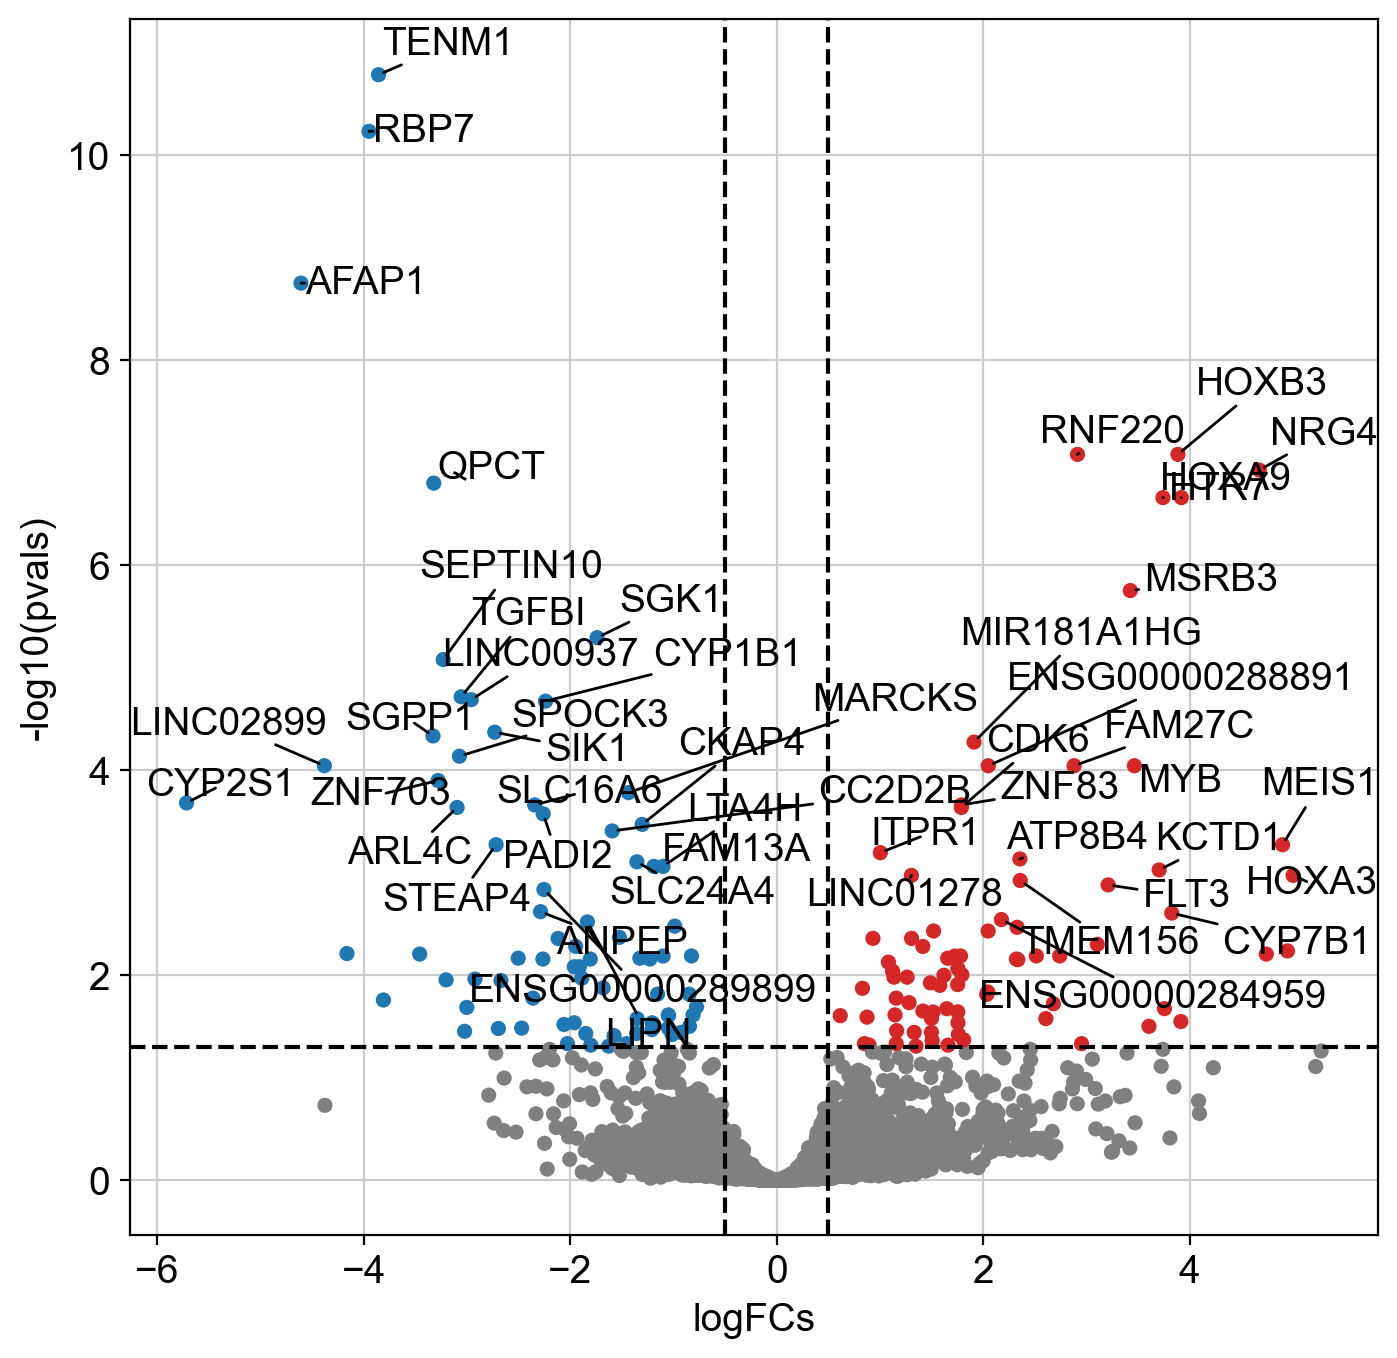

In [40]:
fig = dc.plot_volcano_df(
    results_df,
    x = "log2FoldChange",
    y = "padj",
    top = 50,
    figsize = (8, 8), return_fig = True
)


In [8]:
print(select_cell_type)
mat = results_df[["stat"]].T.rename(index={"stat": select_cell_type})
mat

CD14 Monocytes


,A1BG,A1BG-AS1,A2ML1-AS1,A3GALT2,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,...,ZSWIM9,ZUP1,ZW10,ZWILCH,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
CD14 Monocytes,-0.111011,0.320472,-0.01737,-0.866449,-0.140246,-0.458829,-0.56789,3.352199,0.80695,-1.389491,...,0.776939,-0.245214,-0.383075,0.793516,0.769741,0.566745,0.055191,-1.086739,-0.108969,1.050182


# ORA

In [10]:
# Retrieve MSigDB resource
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


In [12]:
msigdb[msigdb["collection"]=="hallmark"].head()

,genesymbol,collection,geneset
233,MAFF,hallmark,HALLMARK_IL2_STAT5_SIGNALING
250,MAFF,hallmark,HALLMARK_COAGULATION
270,MAFF,hallmark,HALLMARK_HYPOXIA
373,MAFF,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,HALLMARK_COMPLEMENT


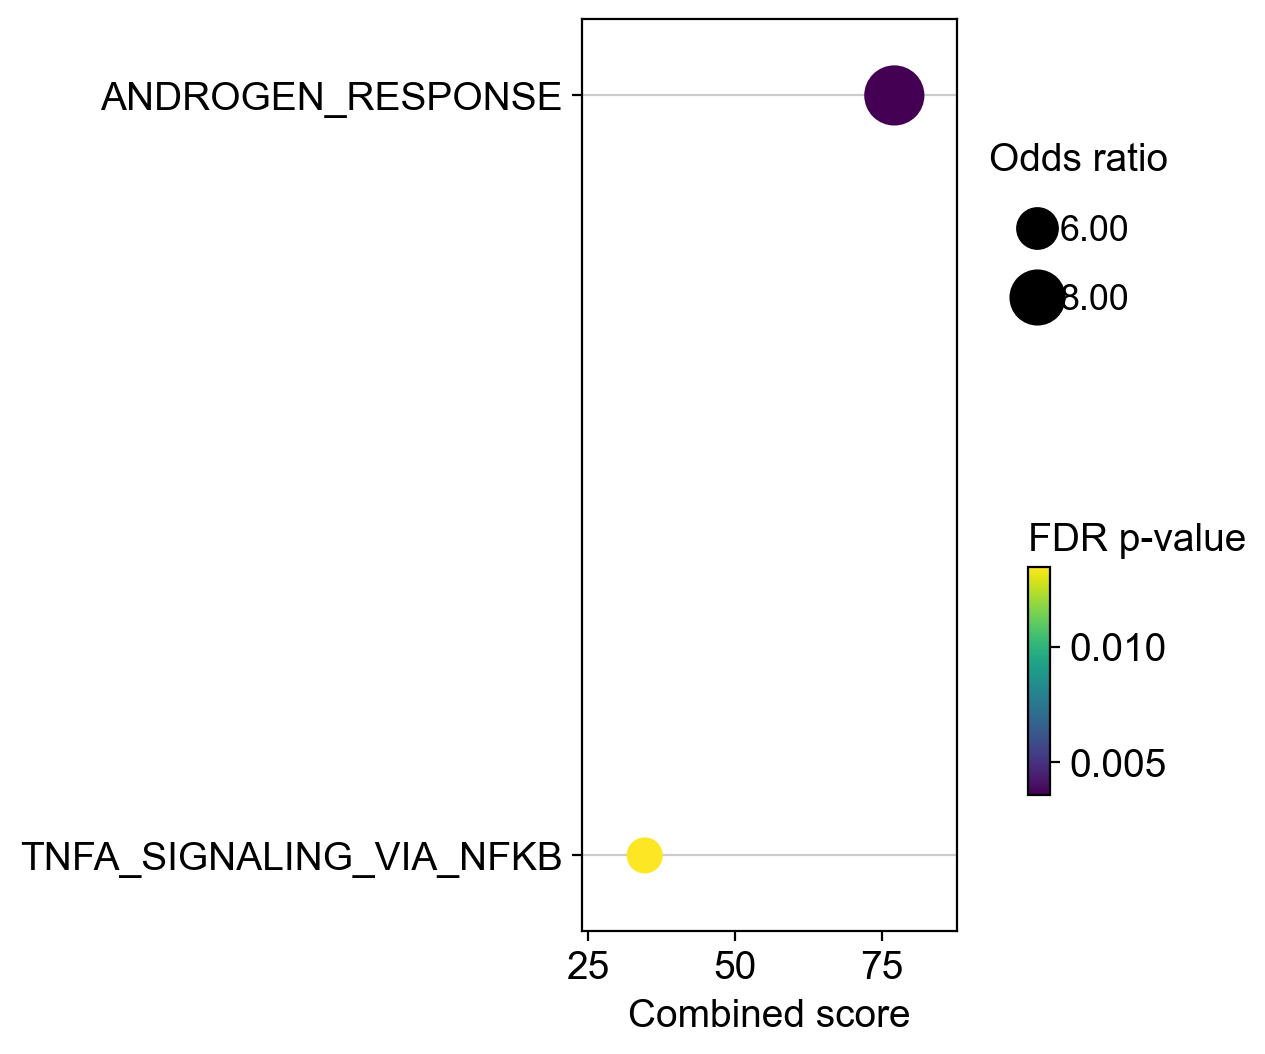

In [13]:
# Filter by hallmark
msigdb_filtered = msigdb[msigdb["collection"]=="hallmark"]

# Remove duplicated entries
msigdb_filtered = msigdb_filtered[~msigdb_filtered.duplicated(["geneset", "genesymbol"])]

# Rename
msigdb_filtered.loc[:, "geneset"] = [name.split("HALLMARK_")[1] for name in msigdb_filtered["geneset"]]

msigdb_filtered

try:
    
    # Infer enrichment with ora using significant deg
    top_genes = results_df[(results_df["padj"] < 0.05)]
    
    # Run ora
    enr_pvals = dc.get_ora_df(
        df = top_genes,
        net = msigdb_filtered,
        source = "geneset",
        target = "genesymbol"
    )
    
    enr_pvals_select = enr_pvals[(enr_pvals["FDR p-value"] < 0.05)].sort_values("Combined score", ascending=False)
    
    dc.plot_dotplot(
        enr_pvals_select,
        x = "Combined score",
        y = "Term",
        s = "Odds ratio",
        c = "FDR p-value",
        cmap = "viridis",
        scale = 0.4,
        figsize=(3, 6)
    )

except Exception as e:
    print(f"Error ignored: {e}")


# GSEA

In [14]:
gsea_hallmark = dc.get_gsea_df(results_df, stat = "stat", net = msigdb_filtered, source="geneset", target="genesymbol")

In [16]:
gsea_hallmark.to_excel("gsea/gsea_cd14_monocytes.xlsx")

In [15]:
gsea_hallmark.sort_values(by = "FDR p-value").head(10)

,Term,ES,NES,NOM p-value,FDR p-value,Set size,Tag %,Rank %,Leading edge
24,INFLAMMATORY_RESPONSE,-0.382544,-1.755929,0.000000,0.000000,129,0.310078,0.173636,GNA15;ICOSLG;SLC7A1;KCNA3;RIPK2;RAF1;MYC;EMP3;...
1,ALLOGRAFT_REJECTION,-0.393759,-1.786534,0.000000,0.000000,135,0.274074,0.105718,HLA-DOA;GPR65;ICOSLG;RIPK2;WARS1;UBE2D1;ACVR2A...
47,UV_RESPONSE_UP,-0.448744,-1.986287,0.000000,0.000000,106,0.443396,0.219118,SULT1A1;JUNB;CEBPG;NFKBIA;IL6ST;PPIF;PSMC3;SQS...
44,TNFA_SIGNALING_VIA_NFKB,-0.431053,-1.988228,0.000000,0.000000,147,0.367347,0.187691,BHLHE40;ICOSLG;PTGS2;RIPK2;JUNB;CEBPD;SLC2A6;M...
35,OXIDATIVE_PHOSPHORYLATION,-0.386530,-1.883508,0.000000,0.000000,196,0.515306,0.321606,ACAA2;CS;NDUFB1;OXA1L;RHOT2;NDUFB8;ATP5MC3;SUC...
31,MYC_TARGETS_V1,-0.394793,-1.885293,0.000000,0.000000,190,0.368421,0.220340,RPL14;SRM;PCBP1;MYC;RPS5;RAD23B;PRPF31;CCT5;CU...
10,COMPLEMENT,-0.332259,-1.541940,0.002165,0.015461,143,0.293706,0.150677,PPP4C;SERPINA1;RAF1;FCN1;MSRB1;USP16;CPQ;PRCP;...
22,IL2_STAT5_SIGNALING,-0.313464,-1.445007,0.013158,0.082237,139,0.237410,0.110083,BHLHE40;GPR65;MYO1E;SCN9A;MYC;SYNGR2;AHR;CD48;...
11,DNA_REPAIR,-0.288595,-1.315441,0.041379,0.229885,135,0.407407,0.298734,ERCC4;RPA3;UMPS;TAF10;TK2;CETN2;ALYREF;SSRP1;E...
12,E2F_TARGETS,0.283283,1.291406,0.053506,0.244051,146,0.273973,0.209690,CSE1L;SMC6;CDC25B;PSIP1;PAICS;CDKN1A;EXOSC8;XP...


INFLAMMATORY_RESPONSE
ALLOGRAFT_REJECTION
UV_RESPONSE_UP
TNFA_SIGNALING_VIA_NFKB
OXIDATIVE_PHOSPHORYLATION
MYC_TARGETS_V1
COMPLEMENT


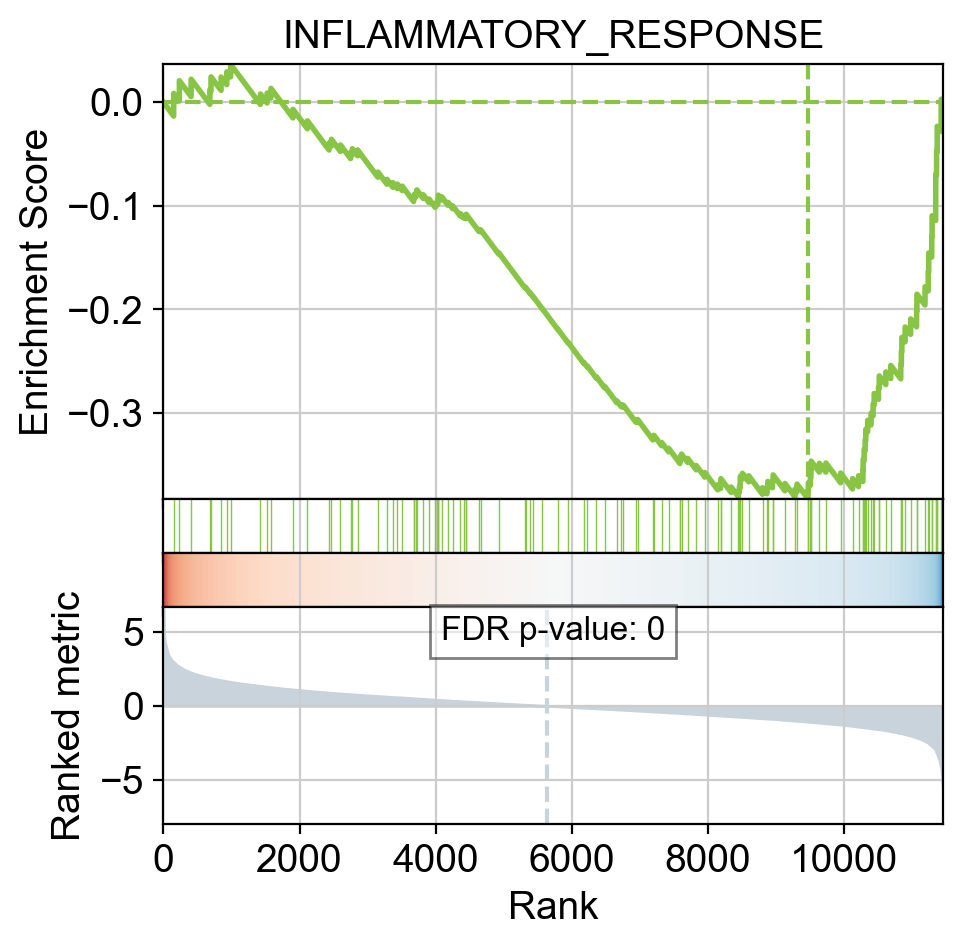

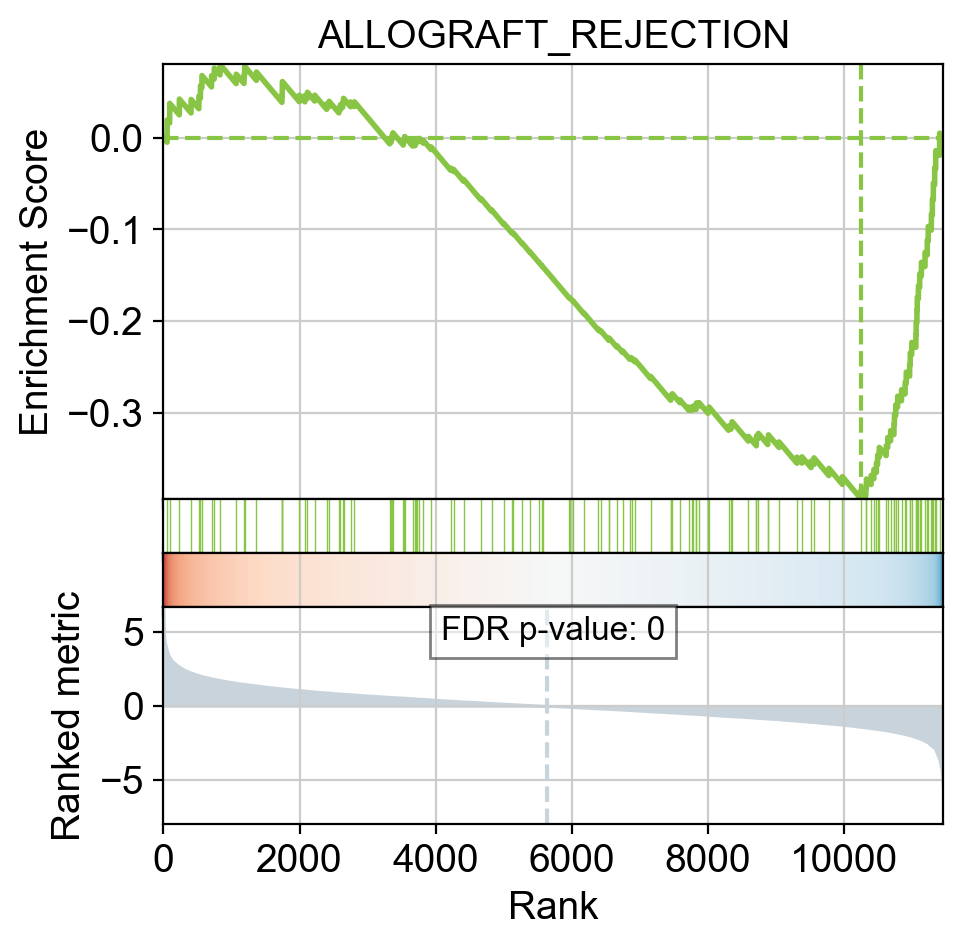

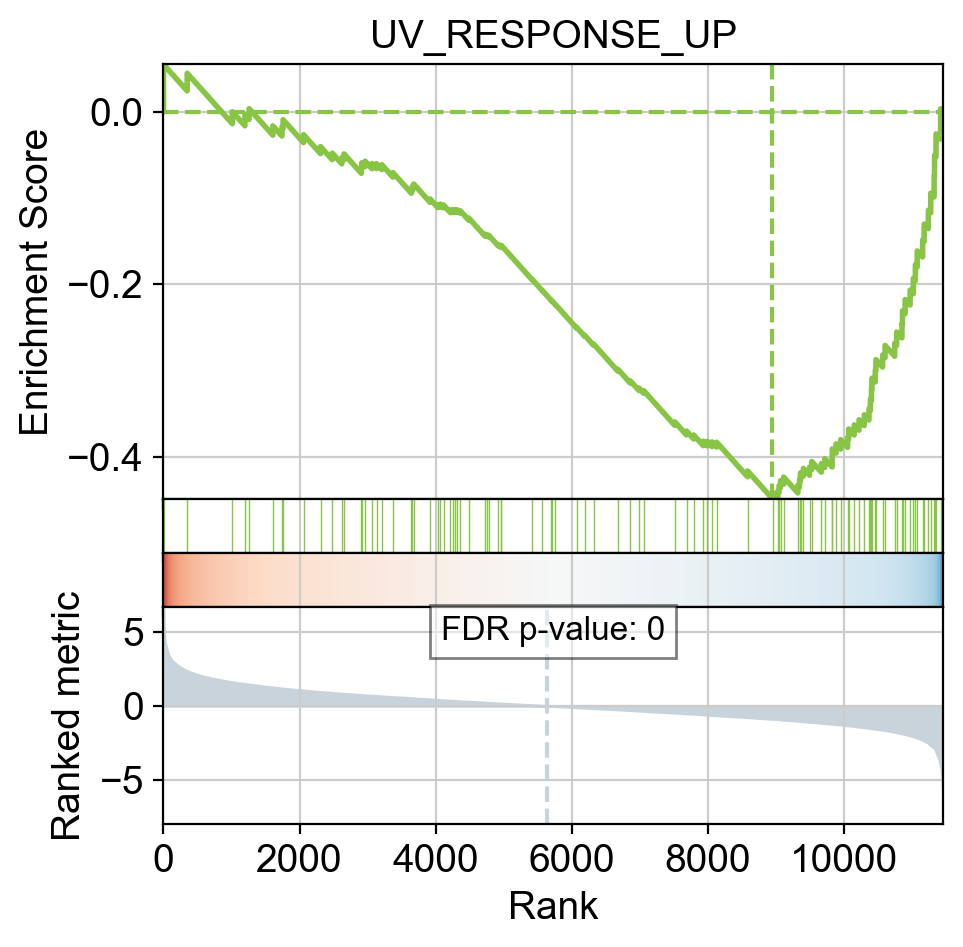

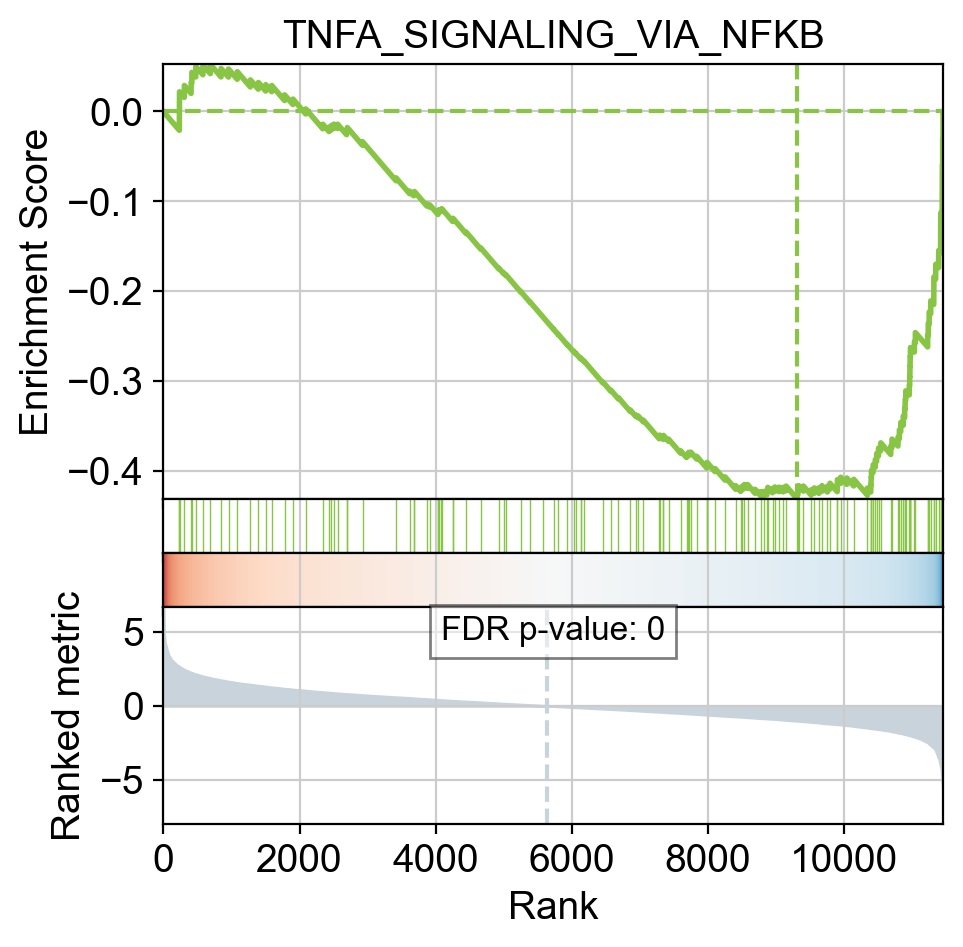

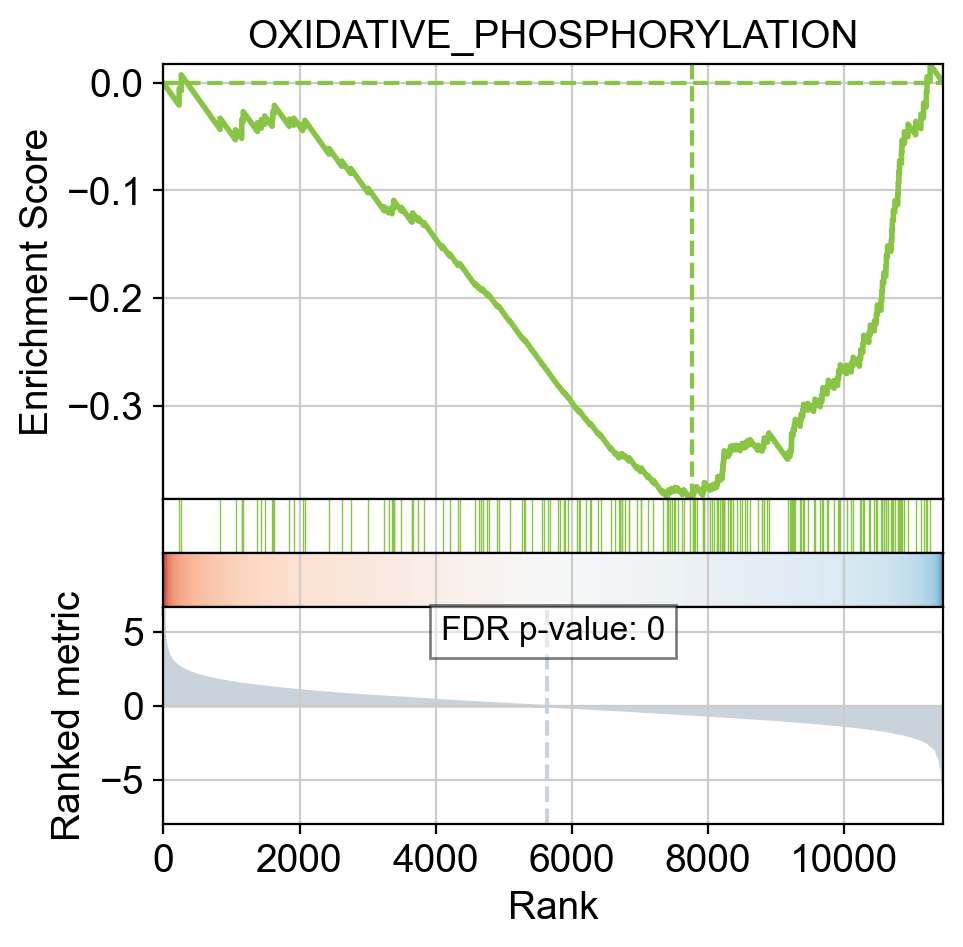

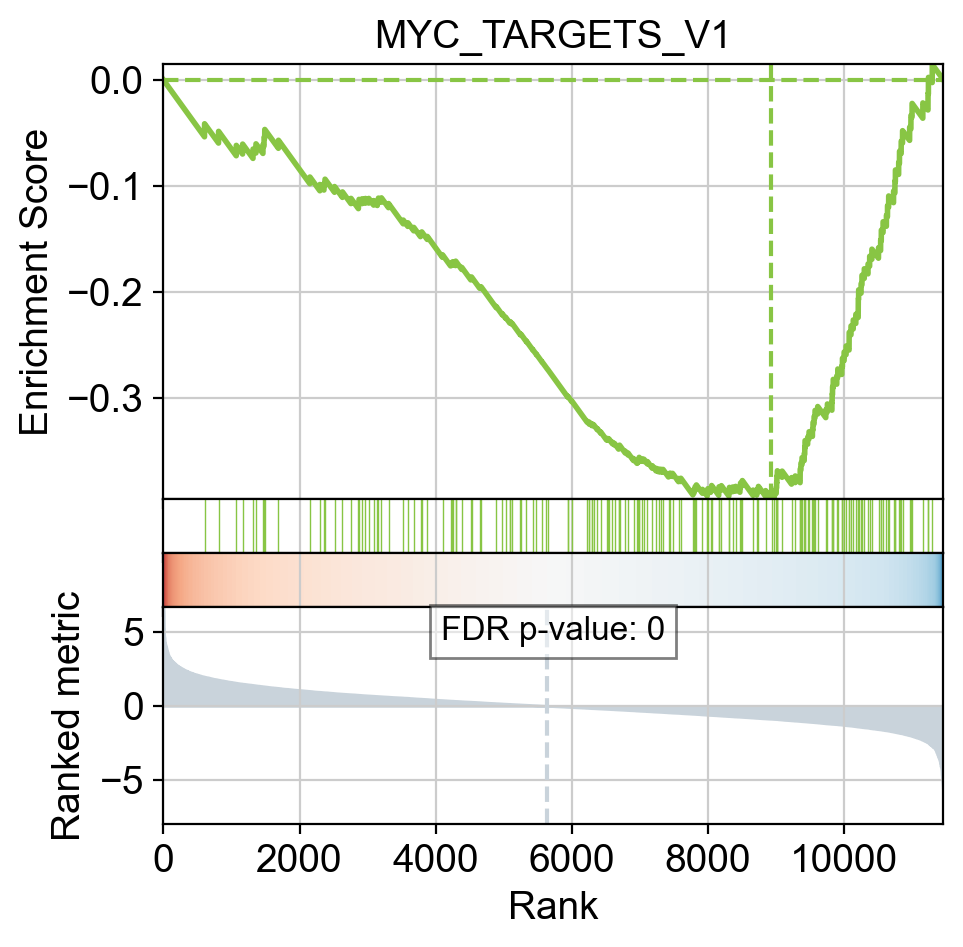

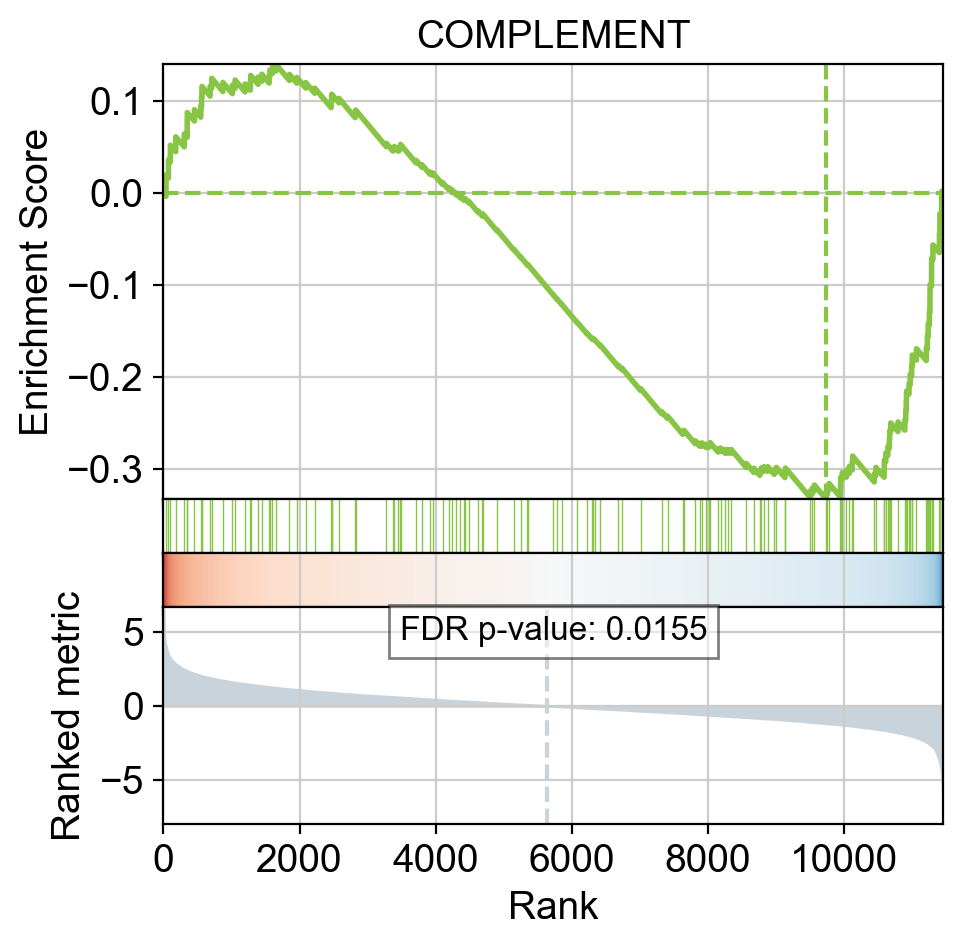

In [17]:
import matplotlib.pyplot as plt

selected_terms = ["INFLAMMATORY_RESPONSE", "ALLOGRAFT_REJECTION", "UV_RESPONSE_UP", "TNFA_SIGNALING_VIA_NFKB", "OXIDATIVE_PHOSPHORYLATION", "MYC_TARGETS_V1", "COMPLEMENT"]


for set_name in selected_terms:
    print(set_name)

    # Extract FDR p-value
    fdr_pval = gsea_hallmark.loc[gsea_hallmark['Term'] == set_name, 'FDR p-value'].values
    if len(fdr_pval) > 0:
        fdr_pval_text = f"FDR p-value: {fdr_pval[0]:.3g}"
    else:
        fdr_pval_text = "FDR p-value: N/A"

    # Create the plot
    fig = dc.plot_running_score(
        df=results_df,
        stat='stat',
        net=msigdb_filtered,
        source='geneset',
        target='genesymbol',
        set_name=set_name,
        return_fig = True
    )


    axes = fig[0].get_axes()
    main_ax = axes[3]


    xlim = main_ax.get_xlim()
    ylim = main_ax.get_ylim()
    x_center = (xlim[0] + xlim[1]) / 2
    y_center = 5

    main_ax.text(x_center, y_center, fdr_pval_text, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))


    plt.savefig(f"figures/final/gsea/pseudobulk_cd14_monocytes_AML_vs_HD_{set_name}.pdf")

